In [33]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import END, StateGraph
import functools
from langchain_core.messages import AIMessage
from typing import Literal
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.retrievers import WikipediaRetriever
from langchain_openai import ChatOpenAI


In [38]:
tavilee = TavilySearchResults()
tool1 = [tavilee]

@tool
def wiki(query):
    """ This is the method to do Wikipedia Search on the argument passed !! """
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    return wikipedia.run(query)
    # retriever = WikipediaRetriever()
    # retriever.invoke("HUNTER X HUNTER")

tool2 = [wiki]

In [30]:
llm = ChatOpenAI()

In [27]:
prompt1 = ChatPromptTemplate.from_messages(
    [
        (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n,"
                "You should provide the exact name of the Chief Miniter Of Telangana , India "
        ),
            MessagesPlaceholder(variable_name="messages"),
    ]
)
prompt1 = prompt1.partial(tool_names=', '.join(tool.name for tool in tool1))
tavily_agent =  prompt1 |llm.bind_tools(tool1)

In [32]:
prompt2 = ChatPromptTemplate.from_messages(
    [
        (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n,"
                "You should do the summarize the response from the tool into 5 liners "
        ),
            MessagesPlaceholder(variable_name="messages"),
    ]
)
prompt2 = prompt2.partial(tool_names=', '.join(tool.name for tool in tool2))
wiki_agent =  prompt2 |llm.bind_tools(tool2)

In [34]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    sender:str

In [35]:
def agent_node(state,agent,name):
    result = agent.invoke(state)
    print("------>>>result  ",result)
    if isinstance(result,ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type","name"}),name=name)
    return {
        "messages":[result],
        "sender":name
    }

In [51]:
tavily_node = functools.partial(agent_node,agent=tavily_agent,name='Search')

wiki_node = functools.partial(agent_node,agent=wiki_agent,name='Wiki')


In [52]:
from langgraph.prebuilt import ToolNode

tools = [tavilee, wiki]
tool_node = ToolNode(tools)

In [53]:
tavily_node

functools.partial(<function agent_node at 0x10952bb00>, agent=ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'tool_names': 'tavily_search_results_json'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['tool_names'], template="You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so

In [54]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state['messages'][-1]
    print("last_message \n\n")
    print(last_message)
    print("last_message \n\n")
    
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [55]:
workflow = StateGraph(AgentState)

workflow.add_node("Search",tavily_node)
workflow.add_node("Wiki",wiki_node)
workflow.add_node("call_tool",tool_node)

In [56]:
workflow.add_conditional_edges(
    "Search",
    router,
    {"continue": "Wiki", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "Wiki",
    router,
    {"continue": "Search", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Search": "Search",
        "Wiki": "Wiki",
    },
) 
workflow.set_entry_point("Search")
graph = workflow.compile()

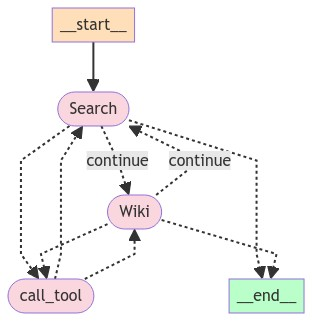

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [58]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Find out the Current Chief Minister of Telangana, India and write a 5 liner about him."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 20},
)
for s in events:
    print(s)
    print("----")

------>>>result   content='' additional_kwargs={'tool_calls': [{'id': 'call_owHhuhx0L63LNHFLB3UZRHbu', 'function': {'arguments': '{"query":"Current Chief Minister of Telangana, India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 221, 'total_tokens': 247}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5d23cf31-8db5-4e56-8553-d0a173abb801-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current Chief Minister of Telangana, India'}, 'id': 'call_owHhuhx0L63LNHFLB3UZRHbu'}]
last_message 


content='' additional_kwargs={'tool_calls': [{'id': 'call_owHhuhx0L63LNHFLB3UZRHbu', 'function': {'arguments': '{"query":"Current Chief Minister of Telangana, India"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 221, 'total_t

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [59]:
llm.invoke("Hi")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}